# Demo of NCut algorithm

This notebook provides a demo of NCut algorithm that I use in my thesis project. You can upload your image to see how well NCut algorithm work to identify the salient object and produce its mask.

## Install and import necessary libraries

In [1]:
%pip install toponetx
%pip install pymatting
%pip install git+https://github.com/lucasb-eyer/pydensecrf.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 704.4/704.4 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 2.7 MB/s eta 0:00:00
  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-k9c7r2d4
  Running command git clone --filter=blob:none --quiet https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-k9c7r2d4
  Resolved https://github.com/lucasb-eyer/pydensecrf.git to commit 2723c7fa4f2ead16ae1ce3d8afe977724bb8f87f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pydensecrf: filename=pydensecrf-1.0-cp310-cp310-linux_x86_64.whl size=3405189 sha256=bfd464c9fcbbddac12fac1390614b29c294cd0edec9e6f3e257e90df3aa5cc9c
  Stored in directory: /tmp/pip-ephem-wheel-cache-mw0c4cs7/wheels/01/5b/61/87443ed3bf03dd2940375cf2f8b6fba88efece935465e490b0
Succes

In [2]:
import torch
import numpy as np
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt
import PIL.Image as Image
from scipy.sparse import csr_matrix, diags, coo_matrix
import toponetx as tnx
import torch.nn as nn
import PIL
from torchvision import transforms
from google.colab import files
from scipy.sparse.linalg import eigsh
from scipy import ndimage
import torch.nn.functional as F
import pydensecrf.densecrf as dcrf
import pydensecrf.utils as utils

## Necessary blocks
These code block should be executed before running the NCut algorithm.
- ViTFeat - to be utilized as feature extractor
- densecrf - CRF implementation to be utilized as post-processor

In [3]:
class ViTFeat(nn.Module):
  """ Vision Transformer """
  def __init__(self, vit_arch='base', vit_feat='k', patch_size=16, vit_model='dino', pretrained_dir=None):
    super().__init__()
    self.vit_feat = vit_feat
    self.patch_size = patch_size
    self.vit_model = vit_model
    dino_dir = "facebookresearch/dino:main"
    dinov2_dir = "facebookresearch/dinov2"

    if self.vit_model == 'dino':
      if vit_arch == 'small':
        if self.patch_size == 16:
          model = torch.hub.load(dino_dir, "dino_vits16")
        elif self.patch_size == 8:
          model = torch.hub.load(dino_dir, "dino_vits8")
        self.feat_dim = 384
      elif vit_arch == 'base':
        if self.patch_size == 16:
          model = torch.hub.load(dino_dir, "dino_vitb16")
        elif self.patch_size == 8:
          model = torch.hub.load(dino_dir, "dino_vitb8")
        self.feat_dim = 768

    model.eval()
    self.model = model

  def forward(self, img):
    if self.vit_model in ['sammed', 'sam', 'sam2']:
      embed = self.model(img)
      bs, feat_dim, h, w = embed.shape[0], embed.shape[1], embed.shape[2], embed.shape[3]
      embed = embed.reshape(bs, feat_dim, h*w)
      return embed

    hook_out = {}
    def hook_fn_forward_qkv(module, input, output):
      hook_out["qkv"] = output
    self.model._modules["blocks"][-1]._modules["attn"]._modules["qkv"].register_forward_hook(hook_fn_forward_qkv)

    def hook_fn_last_attention(module, input, output):
      hook_out["attn"] = output

    if self.vit_model == 'dinov2':
      self.model._modules["blocks"][-1]._modules["attn"]._modules["attn_drop"].register_forward_hook(hook_fn_last_attention)
    elif self.vit_model == 'dino':
      self.model._modules["blocks"][-1]._modules["attn"].register_forward_hook(hook_fn_last_attention)

    # Forward pass in the model
    with torch.no_grad() :
      h, w = img.shape[2], img.shape[3]
      feat_h, feat_w = h // self.patch_size, w // self.patch_size
      if self.vit_model == 'dinov2':
        #outputs = self.model.get_intermediate_layers(img, 12)
        outputs = self.model(img)
        bs, nb_head, nb_token = hook_out["attn"].shape[0], hook_out["attn"].shape[1], hook_out["attn"].shape[2]
      else:
        attentions = self.model.get_last_selfattention(img)
        bs, nb_head, nb_token = attentions.shape[0], attentions.shape[1], attentions.shape[2]

      qkv = (
              hook_out["qkv"]
              .reshape(bs, nb_token, 3, nb_head, -1)
              .permute(2, 0, 3, 1, 4)
          )
      q, k, v = qkv[0], qkv[1], qkv[2]

      k = k.transpose(1, 2).reshape(bs, nb_token, -1)
      q = q.transpose(1, 2).reshape(bs, nb_token, -1)
      v = v.transpose(1, 2).reshape(bs, nb_token, -1)

      # Modality selection
      if self.vit_feat == "k":
        feats = k[:, 1:].transpose(1, 2).reshape(bs, self.feat_dim, feat_h * feat_w)
      elif self.vit_feat == "q":
        feats = q[:, 1:].transpose(1, 2).reshape(bs, self.feat_dim, feat_h * feat_w)
      elif self.vit_feat == "v":
        feats = v[:, 1:].transpose(1, 2).reshape(bs, self.feat_dim, feat_h * feat_w)
      elif self.vit_feat == "kqv":
        k = k[:, 1:].transpose(1, 2).reshape(bs, self.feat_dim, feat_h * feat_w)
        q = q[:, 1:].transpose(1, 2).reshape(bs, self.feat_dim, feat_h * feat_w)
        v = v[:, 1:].transpose(1, 2).reshape(bs, self.feat_dim, feat_h * feat_w)
        feats = torch.cat([k, q, v], dim=1)
      return feats

In [4]:
MAX_ITER = 10
POS_W = 7
POS_XY_STD = 3
Bi_W = 10
Bi_XY_STD = 50
Bi_RGB_STD = 5

def densecrf(image, mask):
    h, w = mask.shape
    mask = mask.reshape(1, h, w)
    fg = mask.astype(float)
    bg = 1 - fg
    output_logits = torch.from_numpy(np.concatenate((bg,fg), axis=0))

    H, W = image.shape[:2]
    image = np.ascontiguousarray(image)

    output_logits = F.interpolate(output_logits.unsqueeze(0), size=(H, W), mode="bilinear").squeeze()
    output_probs = F.softmax(output_logits, dim=0).cpu().numpy()

    c = output_probs.shape[0]
    h = output_probs.shape[1]
    w = output_probs.shape[2]

    U = utils.unary_from_softmax(output_probs)
    U = np.ascontiguousarray(U)

    d = dcrf.DenseCRF2D(w, h, c)
    d.setUnaryEnergy(U)
    d.addPairwiseGaussian(sxy=POS_XY_STD, compat=POS_W)
    d.addPairwiseBilateral(sxy=Bi_XY_STD, srgb=Bi_RGB_STD, rgbim=image, compat=Bi_W)

    Q = d.inference(MAX_ITER)
    Q = np.array(Q).reshape((c, h, w))
    MAP = np.argmax(Q, axis=0).reshape((h,w)).astype(np.float32)
    return MAP

## NCut functions
- To compute;
  - the combined affinity matrix
  - the laplacian matrix
  - the second smallest eigenvector of laplacian matrix
- To detect
  - salient object in image

In [5]:
def knn_affinity(image, n_neighbors=[20, 10], distance_weights=[2.0, 0.1]):
    """Computes a KNN-based affinity matrix. Note that this function requires pymatting"""
    try:
        from pymatting.util.kdtree import knn
    except:
        raise ImportError(
            'Please install pymatting to compute KNN affinity matrices:\n'
            'pip3 install pymatting'
        )

    h, w = image.shape[:2]
    r, g, b = image.reshape(-1, 3).T
    n = w * h

    x = np.tile(np.linspace(0, 1, w), h)
    y = np.repeat(np.linspace(0, 1, h), w)

    i, j = [], []
    for k, distance_weight in zip(n_neighbors, distance_weights):
        f = np.stack(
            [r, g, b, distance_weight * x, distance_weight * y],
            axis=1,
            out=np.zeros((n, 5), dtype=np.float32),
        )

        distances, neighbors = knn(f, f, k=k)

        i.append(np.repeat(np.arange(n), k))
        j.append(neighbors.flatten())

    ij = np.concatenate(i + j)
    ji = np.concatenate(j + i)
    coo_data = np.ones(2 * sum(n_neighbors) * n)

    # This is our affinity matrix
    W = csr_matrix((coo_data, (ij, ji)), (n, n))
    return W

def get_diagonal(W, threshold: float = 1e-12):
  """Gets the diagonal sum of a sparse matrix"""
  try:
      from pymatting.util.util import row_sum
  except:
      raise ImportError(
          'Please install pymatting to compute the diagonal sums:\n'
          'pip3 install pymatting'
      )

  D = row_sum(W)
  D[D < threshold] = 1.0  # Prevent division by zero.
  D = diags(D)
  return D

def compute_eigs(L, D, K: int = 2):
  # Extract eigenvectors
  try:
      eigenvalues, eigenvectors = eigsh(L, sigma=0, k=K, which='LM', M=D)
  except:
      eigenvalues, eigenvectors = eigsh(L, k=K, which='SM', M=D)

  eigenvalues, eigenvectors = torch.from_numpy(eigenvalues), torch.from_numpy(eigenvectors.T).float()

  # Sign ambiguity
  for k in range(eigenvectors.shape[0]):
      if 0.5 < torch.mean((eigenvectors[k] > 0).float()).item() < 1.0:  # reverse segment
          eigenvectors[k] = 0 - eigenvectors[k]

  return eigenvectors

def get_salient_areas(second_smallest_vec):
  # get the area corresponding to salient objects.
  avg = np.sum(second_smallest_vec) / len(second_smallest_vec)
  bipartition = second_smallest_vec > avg  #0
  return bipartition

def check_num_fg_corners(bipartition, dims):
  # check number of corners belonging to the foreground
  bipartition_ = bipartition.reshape(dims)
  top_l, top_r, bottom_l, bottom_r = bipartition_[0][0], bipartition_[0][-1], bipartition_[-1][0], bipartition_[-1][-1]
  nc = int(top_l) + int(top_r) + int(bottom_l) + int(bottom_r)
  return nc

def compute_laplacian(W, lap="comb", s=1.0):
  D = np.array(get_diagonal(W).todense())
  if lap == "comb":
      # combinatorial laplacian
      L = D - W
  elif lap == "norm":
      # normalized laplacian
      D_inv_sqrt = np.linalg.pinv(np.sqrt(D))
      I = np.eye(W.shape[0])
      L = s*I - D_inv_sqrt @ W @ D_inv_sqrt
  elif lap == "rw":
      # random walk laplacian
      D_inv = np.linalg.pinv(D)
      I = np.eye(W.shape[0])
      L = s*I - D_inv @ W
  else:
      raise NotImplementedError()

  return L.astype(np.float32), D.astype(np.float32)

def detect_box(bipartition, seed,  dims, initial_im_size=None, scales=None, principle_object=True):
  """
  Extract a box corresponding to the seed patch. Among connected components extract from the affinity matrix, select the one corresponding to the seed patch.
  """
  w_featmap, h_featmap = dims
  objects, num_objects = ndimage.label(bipartition)
  cc = objects[np.unravel_index(seed, dims)]

  if principle_object:
      mask = np.where(objects == cc)
      # Add +1 because excluded max
      ymin, ymax = min(mask[0]), max(mask[0]) + 1
      xmin, xmax = min(mask[1]), max(mask[1]) + 1
      # Rescale to image size
      r_xmin, r_xmax = scales[1] * xmin, scales[1] * xmax
      r_ymin, r_ymax = scales[0] * ymin, scales[0] * ymax
      pred = [r_xmin, r_ymin, r_xmax, r_ymax]

      # Check not out of image size (used when padding)
      if initial_im_size:
          pred[2] = min(pred[2], initial_im_size[1])
          pred[3] = min(pred[3], initial_im_size[0])

      # Coordinate predictions for the feature space
      # Axis different then in image space
      pred_feats = [ymin, xmin, ymax, xmax]

      return pred, pred_feats, objects, mask
  else:
      raise NotImplementedError

# Image transformation applied to all images
ToTensor = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(
                                (0.485, 0.456, 0.406),
                                (0.229, 0.224, 0.225)),])

## Run NCut algorithm
First upload any desired image to be partitioned.
Then simply run the second code block to extract the bipartitioned area in image as mask.

You can change the parameters of the experiment:
- patch_size: The patch size of feature extractor backbone; 8 or 16
- fixed_size: The fixed size to read the input image.
- laplacian: Which laplacian matrix to compute; comb, norm, rw or hodge
- vit_arch: Backbone architecture; small, base, large
- vit_feat: Vector channel to extract features from. Best features are extracted from 'k'; q, k or v

In [13]:
uploaded = files.upload()

Saving les02.JPG to les02.JPG


In [18]:
patch_size = 16
fixed_size = 480
laplacian = 'comb'
vit_arch = 'small'
vit_feat = 'k'

backbone = ViTFeat(vit_arch=vit_arch, vit_feat=vit_feat, patch_size=patch_size)
backbone.eval()
if torch.cuda.is_available(): backbone.cuda()

# open image
I = Image.open(list(uploaded.keys())[0]).convert('RGB')
image = I.resize((int(fixed_size), int(fixed_size)), PIL.Image.LANCZOS)

# extract feature from backbone
tensor = ToTensor(image).unsqueeze(0)
if torch.cuda.is_available(): tensor = tensor.cuda()
feats = backbone(tensor)[0]

# prepare image and features
H_patch, W_patch = image.size[0] // patch_size, image.size[1] // patch_size
image_rgb = image.resize((H_patch, W_patch), Image.BILINEAR)
image = image_rgb.convert('HSV')
image = np.array(image)
feats = torch.t(feats).cpu().detach().numpy()

### Feature affinities
W_feat = (feats @ feats.T)
W_feat = (W_feat * (W_feat > 0))
W_feat = W_feat / W_feat.max()

### Color affinities
# If we are fusing with color affinites, then load the image and compute
image_color_lambda = 5
if image_color_lambda > 0:
    W_lr = knn_affinity(image, n_neighbors=[20, 10, 5], distance_weights=[0.1, 1.0, 2.0])
    W_color = np.array(W_lr.todense().astype(np.float32))
else:
    # No color affinity
    W_color = 0

# combine affinity matrices
W_comb = W_feat + (W_color * image_color_lambda)

# compute laplacian of the affinity matrix
L, D = compute_laplacian(W_comb, lap=laplacian, s=1.0)

# compute eigenvectors of the laplacian and extract second smallest eigenvector
eigenvecs = compute_eigs(L, D, K=2)
second_eigenvec = eigenvecs[1].numpy()

# get salient area
bipartition = get_salient_areas(second_eigenvec)

# check if we should reverse the partition
dims, scales = [H_patch, H_patch], [patch_size, patch_size]
seed = np.argmax(np.abs(second_eigenvec))

reverse = False
nc = check_num_fg_corners(bipartition, dims)
if nc == 4:
  reverse = True

if reverse:
  # reverse bipartition, eigenvector and get new seed
  second_eigenvec = second_eigenvec * -1
  bipartition = np.logical_not(bipartition)
  seed = np.argmax(second_eigenvec)

# get pixels corresponding to the seed
bipartition = bipartition.reshape(dims).astype(float)
_, _, _, cc = detect_box(bipartition, seed, dims, scales=scales, initial_im_size=dims)
pseudo_mask = np.zeros(dims)
pseudo_mask[cc[0],cc[1]] = 1
pseudo_mask = torch.from_numpy(pseudo_mask)

# upsample pseudo mask to initial image shape
bipartition = F.interpolate(pseudo_mask.unsqueeze(0).unsqueeze(0), size=dims, mode='nearest').squeeze()
bipartition = bipartition.cpu().numpy()
bipartition[bipartition <= 0] = 0

# post-process pesudo-masks with CRF
pseudo_mask = densecrf(np.array(image), bipartition)
pseudo_mask = ndimage.binary_fill_holes(pseudo_mask>=0.5)

# construct binary pseudo-masks
pseudo_mask[pseudo_mask < 0] = 0
pseudo_mask = Image.fromarray(np.uint8(pseudo_mask*255))
pseudo_mask = np.asarray(pseudo_mask.resize((fixed_size, fixed_size)))

pseudo_mask = pseudo_mask.astype(np.uint8)
upper = np.max(pseudo_mask)
lower = np.min(pseudo_mask)
thresh = upper / 2.0
pseudo_mask[pseudo_mask > thresh] = upper
pseudo_mask[pseudo_mask <= thresh] = lower

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


## Plot the salient object mask

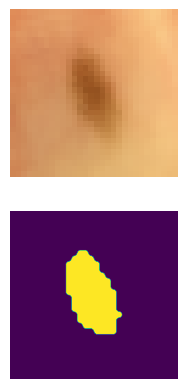

In [20]:
f, axarr = plt.subplots(2, 1)
axarr[0].imshow(image_rgb)
axarr[0].axis('off')
axarr[1].imshow(pseudo_mask)
axarr[1].axis('off')
plt.show()